👋 **Приветствую, Михаил!**

Меня зовут Арсен Абдулин, и я буду твоим ревьювером по проекту. Предлагаю общаться на «ты», если не против =) Моя цель — не поиск ошибок в твоей работе, а поделиться опытом и помочь успешно завершить проект, чтобы на шаг приблизиться к профессии специалиста по Data Science.

Видно, что ты проделал большую работу, она выполнена на хорошем уровне 😊 В целом ты получил положительный результат по проекту, но есть несколько рекомендаций, я отметил в комментариях! 

При проверке работ я делаю следующие комментарии:

<div class="alert alert-success">
<b>✔️ Зеленым цветом</b> отмечены удачные решения, на которые можно опираться в следующих проектах.</div>

<div class="alert alert-warning">
<b>⚠️ Желтым цветом</b> я отметил пункты, которые в следующий раз можно сделать по-другому. Одно-два таких замечания в проекте допускается, но если их много — проект следует доработать. </div>

<div class="alert alert-danger">
<b>🚫 Красным цветом</b> отмечены критические замечания, которые необходимо поправить, чтобы принять проект. </div>

Если какие-то моменты в задании для тебя были непонятны и у тебя есть ко мне вопросы — смело спрашивай 😊 Также ты можешь доработать места, где есть желтые комментарии в этом проекте (однако, это не обязательно).

Предлагаю работать над проектом в диалоге: если ты решишь что-то поменять по моим рекомендациям — пиши об этом (выбери для своих комментариев определенный цвет - так мне будет легче увидеть изменения). Пожалуйста не перемещай, не изменяй и не удаляй мои комментарии. Все это поможет сделать проверку твоего проекта оперативнее.

<div class="alert alert-info"> <b>ℹ️ Комментарий студента: </b> Пример комментария. </div>

<font color=blue>
<b> Вступление:</b> Ввиду необъятности тематики по анализу текстов, хочу предложить несколько полезных ссылок от ревьюверов (если заинтересует):
    
Основы Natural Language Processing для текста  — https://habr.com/ru/company/Voximplant/blog/446738/
    
Интересная статья в общем по NLP — https://habr.com/ru/company/oleg-bunin/blog/352614/
    
BERT, ELMO и Ко в картинках (как в NLP пришло трансферное обучение) — https://habr.com/ru/post/487358/
    
В частности, BERT является довольно популярной моделью. Вот еще информация по этой модели:
    
https://habr.com/ru/post/436878/
    
http://jalammar.github.io/illustrated-bert/; https://huggingface.co/docs/transformers/model_doc/bert
    
И другие ссылки: 
    
http://jalammar.github.io/illustrated-word2vec/
    
https://colah.github.io/posts/2015-08-Understanding-LSTMs/
    
http://jalammar.github.io/illustrated-transformer/
    
https://colab.research.google.com/drive/1SBha91u6142pW5mSiQOOjJWCCSAFj4HI?usp=sharing    
 
</font>   

<div class="alert alert-info"> <b>ℹ️ Комментарий студента: </b> Спасибо за источники! Постепенно буду изучать по мере необходимости </div>

<div class="alert alert-success">
<b>✔️ Комментарий ревьювера (v2):</b> Хорошо, работу принимаю!
    
Желаю успехов в дальнейших проектах =)

</div>

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Балансировка-данных" data-toc-modified-id="Балансировка-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Балансировка данных</a></span><ul class="toc-item"><li><span><a href="#Уменьшение-размера-весов-классов" data-toc-modified-id="Уменьшение-размера-весов-классов-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Уменьшение размера весов классов</a></span></li><li><span><a href="#Ресемплинг-с-уменшением-класса-0" data-toc-modified-id="Ресемплинг-с-уменшением-класса-0-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Ресемплинг с уменшением класса 0</a></span></li></ul></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Классификатор-LogisticRegression" data-toc-modified-id="Классификатор-LogisticRegression-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Классификатор LogisticRegression</a></span></li><li><span><a href="#Классификатор-DecisionTreeClassifier" data-toc-modified-id="Классификатор-DecisionTreeClassifier-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Классификатор DecisionTreeClassifier</a></span></li><li><span><a href="#Классификатор-CatBoostClassifier" data-toc-modified-id="Классификатор-CatBoostClassifier-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Классификатор CatBoostClassifier</a></span></li><li><span><a href="#Вывод-по-классификаторам" data-toc-modified-id="Вывод-по-классификаторам-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Вывод по классификаторам</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

<div class="alert alert-success">
<b>✔️ Комментарий ревьювера:</b> Хорошо, что есть небольшое описание и содержание проекта.

</div>

## Подготовка

In [1]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

<div class="alert alert-success">
<b>✔️ Комментарий ревьювера:</b> Необходимые библиотеки загружены, ничего лишнего.

</div>

In [2]:
toxic_comments = pd.read_csv('/datasets/toxic_comments.csv')
toxic_comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [3]:
toxic_comments.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [4]:
#Посмотрим сколько у нас токсичных/нектоксичных текстов
display(toxic_comments['toxic'].value_counts())
#Выведем соотношение
class_ratio = toxic_comments['toxic'].value_counts()[0] / toxic_comments['toxic'].value_counts()[1]
class_ratio

0    143346
1     16225
Name: toxic, dtype: int64

8.834884437596301

<div class="alert alert-success">
<b>✔️ Комментарий ревьювера:</b> Здорово что посмотрел несколько строчек отзывов и обратил внимание на баланс классов.

</div>

**Вывод**

Видим что классы несбалансированы, применем несколько спомобов балансировки и сравним их

<div class="alert alert-danger">
<b>🚫 Комментарий ревьювера:</b> К сожалению mystem подходит только для русского языка. Проще всего поправить:
    
    lemmatizer = WordNetLemmatizer()
   
</div>

<div class="alert alert-info"> <b>ℹ️ Комментарий студента: </b> Поправил </div>

<div class="alert alert-success">
<b>✔️ Комментарий ревьювера (v2):</b> Отлично =)

</div>

In [5]:
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    text = text.lower()
    lemm_text = "".join(lemmatizer.lemmatize(text))
    cleared_text = re.sub(r'[^a-zA-Z]', ' ', lemm_text) 
    return " ".join(cleared_text.split())

toxic_comments['lemm_text'] = toxic_comments['text'].apply(lemmatize_text)

toxic_comments = toxic_comments.drop(['text'], axis=1)

<div class="alert alert-warning">
<b>⚠️ Комментарий ревьювера:</b> Преобразование в юникод здесь не нужно, т.к. текст на английском языке. Это также немного сэкономит время.
   
</div>

<div class="alert alert-success">
<b>✔️ Комментарий ревьювера:</b> На будущее, если будет интересно более углубленное изучение анализа текстов, могу посоветовать для более точной лемматизации использовать POS-теги, это сделает лемматизацию точнее:

https://webdevblog.ru/podhody-lemmatizacii-s-primerami-v-python/
    
Это занимает больше времени, поэтому можешь проверить локально, на небольшой выборке. Также используют метод pos_tag_sents(), когда перебор идет не по словам, а по предложениям — это немного быстрее.
</div>

In [6]:
# Разобьем выборку по отношению 50/20/20. Уменьшим количество кроссвалидаций до 3 из-за размера выборки.
target = toxic_comments['toxic']
features = toxic_comments.drop(['toxic'], axis=1)

features_train, features_valid, target_train, target_valid = train_test_split(features, 
                                                                              target, 
                                                                              test_size=0.5, 
                                                                              random_state=1515)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, 
                                                                            target_valid, 
                                                                            test_size=0.5,
                                                                            random_state=1515)

nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

count_tf_idf = TfidfVectorizer(stop_words=stopwords)

features_train = count_tf_idf.fit_transform(features_train['lemm_text'].values.astype('U'))
features_valid = count_tf_idf.transform(features_valid['lemm_text'].values.astype('U'))
features_test = count_tf_idf.transform(features_test['lemm_text'].values.astype('U'))
print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)
cv_counts = 2

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


(79785, 113310)
(39893, 113310)
(39893, 113310)


In [7]:
classificator = LogisticRegression()
train_f1 = cross_val_score(classificator, 
                      features_train, 
                      target_train, 
                      cv=cv_counts, 
                      scoring='f1').mean()
print('F1 на CV', train_f1)

F1 на CV 0.6295275432105886


<div class="alert alert-warning">
<b>⚠️ Комментарий ревьювера:</b> Поскольку ты используешь кросс-валидацию, валидационный набор данных тебе уже не нужен. На кросс-валидации подбираются лучшие параметры модели, которые потом ты оцениваешь на тестовой выборке.
    
    
   
</div>

### Балансировка данных

#### Уменьшение размера весов классов

<div class="alert alert-success">
<b>✔️ Комментарий ревьювера:</b> Хорошо, что учитываешь баланс классов и попробовал разные способы устранения дисбаланса.

</div>

In [8]:
dict_classes={0:1, 1:class_ratio}
classificator = LogisticRegression(class_weight=dict_classes)
train_f1_ballanced = cross_val_score(classificator, 
                                    features_train, 
                                    target_train, 
                                    cv=cv_counts, 
                                    scoring='f1').mean()
print('F1 на CV с балансированными классами', train_f1_ballanced)

F1 на CV с балансированными классами 0.752627338687931


In [9]:
classificator = LogisticRegression(class_weight='balanced')
train_f1_balanced = cross_val_score(classificator, 
                                    features_train, 
                                    target_train, 
                                    cv=cv_counts, 
                                    scoring='f1').mean()
print('F1 на CV с балансированными классами', train_f1_ballanced)

F1 на CV с балансированными классами 0.752627338687931


#### Ресемплинг с уменшением класса 0

In [10]:
toxic_comments_train = toxic_comments.iloc[target_train.index]

target_train_class_zero = toxic_comments_train[toxic_comments_train['toxic'] == 0]['toxic']
target_train_class_one = toxic_comments_train[toxic_comments_train['toxic'] == 1]['toxic']

In [11]:
target_train_class_zero_downsample = target_train_class_zero.sample(target_train_class_one.shape[0],
                                                                    random_state=12082020)
target_train_downsample = pd.concat([target_train_class_zero_downsample, target_train_class_one])

features_train_downsample = toxic_comments.iloc[target_train_downsample.index]
features_train_downsample, target_train_downsample = shuffle(features_train_downsample,
                                                             target_train_downsample,
                                                             random_state=12082020)
features_train_downsample = count_tf_idf.transform(features_train_downsample['lemm_text']
                                                   .values.astype('U'))

In [12]:
classificator = LogisticRegression()
train_f1_downsampled = cross_val_score(classificator,
                      features_train_downsample, 
                      target_train_downsample, 
                      cv=cv_counts, 
                      scoring='f1').mean()
print('F1 на CV с уменьшением классов', train_f1_downsampled)

F1 на CV с уменьшением классов 0.8760987315149515


Видим значительный прирост f1 меры

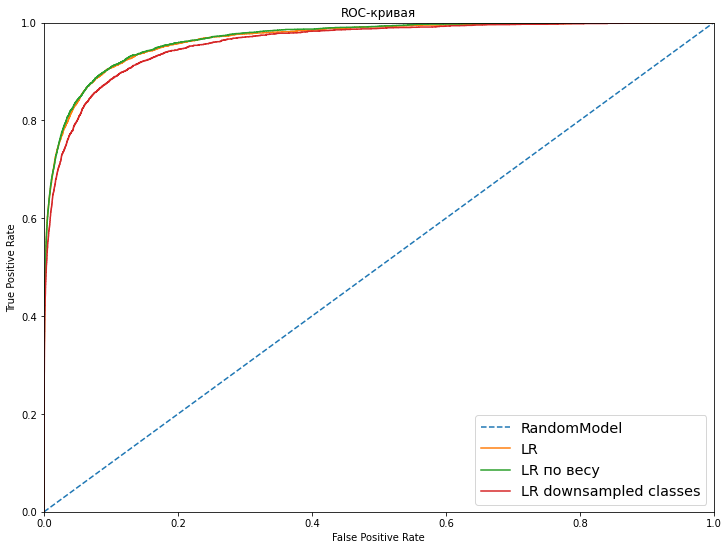

In [13]:
# Построим ROC-AUC графики балансировки
plt.figure(figsize=[12,9])

plt.plot([0, 1], [0, 1], linestyle='--', label='RandomModel')


classificator = LogisticRegression()
classificator.fit(features_train, target_train)
probabilities_valid = classificator.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
valid_f1 = f1_score(target_valid, classificator.predict(features_valid))
plt.plot(fpr, tpr, label='LR')

classificator = LogisticRegression(class_weight=dict_classes)
classificator.fit(features_train, target_train)
probabilities_valid = classificator.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc_balanced = roc_auc_score(target_valid, probabilities_one_valid)
valid_f1_balanced = f1_score(target_valid, classificator.predict(features_valid))
plt.plot(fpr, tpr, label='LR по весу')

classificator = LogisticRegression()
classificator.fit(features_train_downsample,target_train_downsample)
probabilities_valid = classificator.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc_downsampled = roc_auc_score(target_valid, probabilities_one_valid)
valid_f1_downsampled = f1_score(target_valid, classificator.predict(features_valid))
plt.plot(fpr, tpr, label='LR downsampled classes')

plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend(loc='lower right', fontsize='x-large')

plt.title("ROC-кривая")
plt.show()

In [14]:
# Построим таблицу результатов баллансировки
index = ['LogisticRegression',
         'LR по весу',
         'LR downsampled classes']
data = {'F1 на CV':[train_f1,
                    train_f1_balanced,
                    train_f1_downsampled],
        'F1 на валидации':[valid_f1,
                           valid_f1_balanced,
                           valid_f1_downsampled],
        'AUC-ROC':[auc_roc,
                   auc_roc_balanced,
                   auc_roc_downsampled]}

scores_data = pd.DataFrame(data=data, index=index)
scores_data

,F1 на CV,F1 на валидации,AUC-ROC
LogisticRegression,0.629528,0.713912,0.966654
LR по весу,0.744455,0.755414,0.968059
LR downsampled classes,0.876099,0.690821,0.958982


**Вывод**

1) В ходе подготовки данных мы получили признаки для обучения, получили обучающую, валидационную и тестовую выборку.

2) По итогу балансировки даееых мо поняли что баланс по весам самый оптимальный, с ним и работаем дальше

<div class="alert alert-success">
<b>✔️ Комментарий ревьювера:</b> Правильный вывод.

</div>

## Обучение

### Классификатор LogisticRegression

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

<div class="alert alert-warning">
<b>⚠️ Комментарий ревьювера:</b> Рекомендация на будущее:
    
Хочу обратить внимание, что когда используется кросс-валидация, получается, что модель в итоге обучается на всей обучающей выборке и это немного не правильно. В таких случаях рекомендуется оборачивать конструкцию в Pipeline. Вот здесь можно посмотреть примеры применения:
    
https://medium.com/analytics-vidhya/ml-pipelines-using-scikit-learn-and-gridsearchcv-fe605a7f9e05
    
https://habr.com/ru/post/538458/
    
Pipeline + GridSearchCV: https://towardsdatascience.com/nlp-with-pipeline-gridsearch-5922266e82f4
    
Таким образом в GridSearchCV можно добавить пайплайн — но это не обязательно для выполнения данной работы.
</div>

In [15]:
classificator = LogisticRegression()
hyperparams = [{'solver':['newton-cg', 'lbfgs', 'liblinear'],
                'C':[0.1, 1, 10],
                'class_weight':[dict_classes]}]


print('# Tuning hyper-parameters for f1_score')
print()
clf = GridSearchCV(classificator, hyperparams, scoring='f1',cv=cv_counts)
clf.fit(features_train, target_train)
print("Best parameters set found on development set:")
print()
LR_best_params = clf.best_params_
print(LR_best_params)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% (mean, params))
print()

cv_f1_LR = max(means)

# Tuning hyper-parameters for f1_score

Best parameters set found on development set:

{'C': 10, 'class_weight': {0: 1, 1: 8.834884437596301}, 'solver': 'liblinear'}

Grid scores on development set:

0.712701 for {'C': 0.1, 'class_weight': {0: 1, 1: 8.834884437596301}, 'solver': 'newton-cg'}
0.712701 for {'C': 0.1, 'class_weight': {0: 1, 1: 8.834884437596301}, 'solver': 'lbfgs'}
0.712733 for {'C': 0.1, 'class_weight': {0: 1, 1: 8.834884437596301}, 'solver': 'liblinear'}
0.752671 for {'C': 1, 'class_weight': {0: 1, 1: 8.834884437596301}, 'solver': 'newton-cg'}
0.752627 for {'C': 1, 'class_weight': {0: 1, 1: 8.834884437596301}, 'solver': 'lbfgs'}
0.752451 for {'C': 1, 'class_weight': {0: 1, 1: 8.834884437596301}, 'solver': 'liblinear'}
0.761588 for {'C': 10, 'class_weight': {0: 1, 1: 8.834884437596301}, 'solver': 'newton-cg'}
0.761012 for {'C': 10, 'class_weight': {0: 1, 1: 8.834884437596301}, 'solver': 'lbfgs'}
0.761714 for {'C': 10, 'class_weight': {0: 1, 1: 8.834884437596301}, 'solver

In [16]:
classificator = LogisticRegression()
classificator.set_params(**LR_best_params)
classificator.fit(features_train, target_train)
target_predict = classificator.predict(features_valid)
valid_f1_LR = f1_score(target_valid, target_predict)
print('F1 на cv', cv_f1_LR)
print('F1 на валидации', valid_f1_LR)

F1 на cv 0.7617142807393251
F1 на валидации 0.7598688206000243


<div class="alert alert-success">
<b>✔️ Комментарий ревьювера:</b> Проверял твой проект локально. Необходимый порог по F-мере пройден =)

</div>

### Классификатор DecisionTreeClassifier

In [17]:
classificator = DecisionTreeClassifier()
hyperparams = [{'max_depth':[x for x in range(50,100,2)],
                'random_state':[1515],
                'class_weight':[dict_classes]}]


print('# Tuning hyper-parameters for f1_score')
print()
clf = GridSearchCV(classificator, hyperparams, scoring='f1',cv=cv_counts)
clf.fit(features_train, target_train)
print("Best parameters set found on development set:")
print()
DTC_best_params = clf.best_params_
print(DTC_best_params)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% (mean, params))
print()

cv_f1_DTC = max(means)

# Tuning hyper-parameters for f1_score

Best parameters set found on development set:

{'class_weight': {0: 1, 1: 8.834884437596301}, 'max_depth': 94, 'random_state': 1515}

Grid scores on development set:

0.611997 for {'class_weight': {0: 1, 1: 8.834884437596301}, 'max_depth': 50, 'random_state': 1515}
0.614860 for {'class_weight': {0: 1, 1: 8.834884437596301}, 'max_depth': 52, 'random_state': 1515}
0.615978 for {'class_weight': {0: 1, 1: 8.834884437596301}, 'max_depth': 54, 'random_state': 1515}
0.619181 for {'class_weight': {0: 1, 1: 8.834884437596301}, 'max_depth': 56, 'random_state': 1515}
0.620909 for {'class_weight': {0: 1, 1: 8.834884437596301}, 'max_depth': 58, 'random_state': 1515}
0.623856 for {'class_weight': {0: 1, 1: 8.834884437596301}, 'max_depth': 60, 'random_state': 1515}
0.629434 for {'class_weight': {0: 1, 1: 8.834884437596301}, 'max_depth': 62, 'random_state': 1515}
0.632276 for {'class_weight': {0: 1, 1: 8.834884437596301}, 'max_depth': 64, 'random_state': 1515}
0

In [18]:
classificator = DecisionTreeClassifier()
classificator.set_params(**DTC_best_params)
classificator.fit(features_train, target_train)
target_predict = classificator.predict(features_valid)
valid_f1_DTC = f1_score(target_valid, target_predict)
print('F1 на cv', cv_f1_DTC)
print('F1 на валидации', valid_f1_DTC)

F1 на cv 0.6395932522862442
F1 на валидации 0.6322625536356257


### Классификатор CatBoostClassifier

In [19]:
classificator = CatBoostClassifier(verbose=False, iterations=250)
classificator.fit(features_train, target_train)
target_predict = classificator.predict(features_valid)
cv_f1_CBC = cross_val_score(classificator,
                                         features_train, 
                                         target_train, 
                                         cv=cv_counts, 
                                         scoring='f1').mean()
valid_f1_CBC = f1_score(target_valid, target_predict)
print('F1 на cv', cv_f1_CBC)
print('F1 на валидации', valid_f1_CBC)

F1 на cv 0.7118366749528184
F1 на валидации 0.7374779021803183


### Вывод по классификаторам

In [20]:
index = ['LogisticRegression',
         'DecisionTreeClassifier',
         'CatBoostClassifier']
data = {'F1 на CV':[cv_f1_LR,
                    cv_f1_DTC,
                    cv_f1_CBC],
        'F1 на валидации':[valid_f1_LR,
                           valid_f1_DTC,
                           valid_f1_CBC]}

scores_data = pd.DataFrame(data=data, index=index)
scores_data['Выполнение задачи'] = scores_data['F1 на валидации'] > 0.75
scores_data

,F1 на CV,F1 на валидации,Выполнение задачи
LogisticRegression,0.761714,0.759869,True
DecisionTreeClassifier,0.639593,0.632263,False
CatBoostClassifier,0.711837,0.737478,False


**Вывод**

К тестовому набору данных перейдут LogisticRegression

## Выводы

Метрики LogisticRegression
ROC AUC: 0.9603640219232238
F1: 0.7582300884955753
Precision: 0.7325581395348837
Recall: 0.7857666911225238
Accuracy: 0.9486376055949666



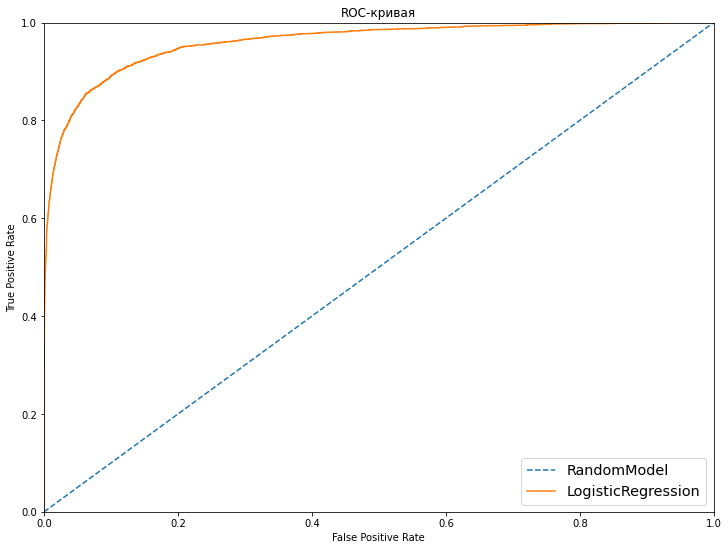

In [21]:
plt.figure(figsize=[12,9])

plt.plot([0, 1], [0, 1], linestyle='--', label='RandomModel')


classificator = LogisticRegression()
classificator.set_params(**LR_best_params)
classificator.fit(features_train, target_train)
probabilities_test = classificator.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
predict_test = classificator.predict(features_test)
plt.plot(fpr, tpr, label='LogisticRegression')
print('Метрики LogisticRegression')
print('ROC AUC:', roc_auc_score(target_test, probabilities_one_test))
print('F1:', f1_score(target_test, predict_test))
print('Precision:', precision_score(target_test, predict_test))
print('Recall:', recall_score(target_test, predict_test))
print('Accuracy:', accuracy_score(target_test, predict_test))
print()

plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend(loc='lower right', fontsize='x-large')

plt.title("ROC-кривая")
plt.show()

# Вывод
Было прделано:
1) Подготовленны данные обучения.

2) Выбран способ баланса классов, сформированы обучающая, валидационная и тестовая выборка.

3) Обучены модели и выбрана лучшая из них на валидационной выборке.

4) Показаны параметры качества моделей.

**Исходные данные обладают большим количеством признаков.** Созданных столбцов больше, чем записей данных. Лучшая модель стала LogisticRegression. 

**CatBoostClassifier может показать себя очень хорошо при долгом обучении на данных.** 

<font color=blue>
<b> ✔️ 👍Заключение ревьювера:</b> Михаил, у тебя хорошая работа, получен положительный результат! 
   
Работа выполнена успешно, код структурирован, правильные выводы! Здорово, что попробовал разные модели и удалось подобрать наилучшие параметры.
    
Основное замечание по работе — нужно поменять лемматизатор. В остальном я отметил рекомендации =)
    
Отправляю работу для ознакомления с ходом проверки, а также если есть вопросы — смело задавай их, я постараюсь тебе помочь 😊

Жду твоего ответа!
</font>

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны